In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv


In [2]:
# Gerekli kütüphaneleri yükleyelim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# İngilizce stopwords (kısa liste, ihtiyaca göre genişletilebilir)
stop_words = set([
    'a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and',
    'any', 'are', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below',
    'between', 'both', 'but', 'by', 'could', 'did', 'do', 'does', 'doing', 'down',
    'during', 'each', 'few', 'for', 'from', 'further', 'had', 'has', 'have', 'having',
    'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i',
    'if', 'in', 'into', 'is', 'it', 'its', 'itself', 'just', 'me', 'more', 'most',
    'my', 'myself', 'no', 'nor', 'not', 'now', 'of', 'off', 'on', 'once', 'only',
    'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 's', 'same',
    'she', 'should', 'so', 'some', 'such', 't', 'than', 'that', 'the', 'their',
    'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this',
    'those', 'through', 'to', 'too', 'under', 'until', 'up', 'very', 'was', 'we',
    'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will',
    'with', 'you', 'your', 'yours', 'yourself', 'yourselves'
])

# Temizleme fonksiyonu
def temizle(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

# Veri setini oku
df = pd.read_csv("/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv")


# Temizlenmiş yorum sütunu oluştur
df['cleaned_review'] = df['Review Text'].apply(temizle)



# İlk bakış
print(df.shape)
print(df.columns)
df.head()


(23486, 12)
Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name', 'cleaned_review'],
      dtype='object')


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,cleaned_review
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,absolutely wonderful silky sexy comfortable
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,love dress sooo pretty happened find store im ...
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,high hopes dress really wanted work initially ...
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,love love love jumpsuit fun flirty fabulous ev...
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,shirt flattering due adjustable front tie perf...


In [3]:
# Kolon adlarını sadeleştirelim
df.columns = df.columns.str.replace(' ', '_')

# Yorum olmayan satırları düşür
df = df[~df.Review_Text.isnull()]

# Gerekli olmayan sütunları çıkar (isteğe bağlı)
df = df[['Clothing_ID', 'Age', 'Title', 'Review_Text', 'Rating', 'Recommended_IND', 'Positive_Feedback_Count', 'Class_Name', 'Department_Name', 'Division_Name']]

# Eksik verileri kontrol et
print(df.isnull().sum())

# Eksik başlıkları dolduralım (boş olursa işimizi engellemez ama NLP için gerekebilir)
df['Title'] = df['Title'].fillna("No Title")


Clothing_ID                   0
Age                           0
Title                      2966
Review_Text                   0
Rating                        0
Recommended_IND               0
Positive_Feedback_Count       0
Class_Name                   13
Department_Name              13
Division_Name                13
dtype: int64


In [4]:
def clean_text(text):
    # Küçük harfe çevir
    text = text.lower()
    # Noktalama işaretlerini kaldır
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    # Sayıları kaldır
    text = re.sub(r"\d+", "", text)
    # Fazla boşlukları tek boşluğa indir
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["Clean_Review"] = df["Review_Text"].apply(clean_text)


In [5]:
import nltk
nltk.data.path.append("/tam/yol/nltk_data")  # örneğin: "/home/kullanici/nltk_data"

def remove_stopwords(text):
    tokens = nltk.word_tokenize(text)
    filtered = [word for word in tokens if word not in stop_words]
    return " ".join(filtered)

df["Clean_Review"] = df["Clean_Review"].apply(remove_stopwords)

df[["Review_Text", "Clean_Review"]].head(10)


,Review_Text,Clean_Review
0,Absolutely wonderful - silky and sexy and comf...,absolutely wonderful silky sexy comfortable
1,Love this dress! it's sooo pretty. i happene...,love dress sooo pretty happened find store im ...
2,I had such high hopes for this dress and reall...,high hopes dress really wanted work initially ...
3,"I love, love, love this jumpsuit. it's fun, fl...",love love love jumpsuit fun flirty fabulous ev...
4,This shirt is very flattering to all due to th...,shirt flattering due adjustable front tie perf...
5,"I love tracy reese dresses, but this one is no...",love tracy reese dresses one petite feet tall ...
6,I aded this in my basket at hte last mintue to...,aded basket hte last mintue see would look lik...
7,"I ordered this in carbon for store pick up, an...",ordered carbon store pick ton stuff always try...
8,I love this dress. i usually get an xs but it ...,love dress usually get xs runs little snug bus...
9,"I'm 5""5' and 125 lbs. i ordered the s petite t...",im lbs ordered petite make sure length wasnt l...


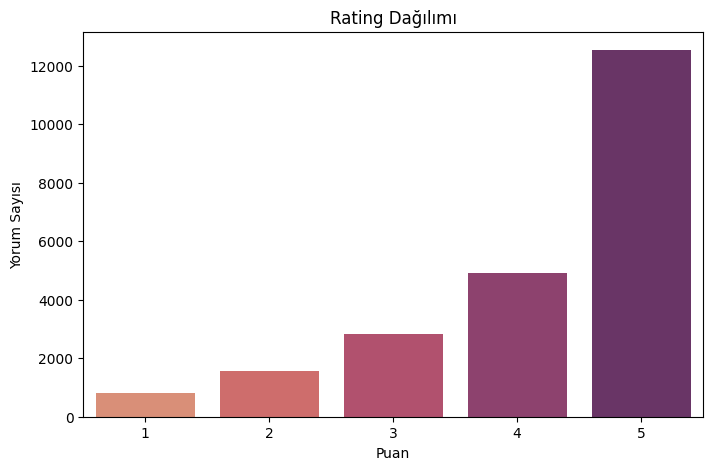

In [6]:
plt.figure(figsize=(8, 5))
sns.countplot(x="Rating", data=df, palette="flare")
plt.title("Rating Dağılımı")
plt.xlabel("Puan")
plt.ylabel("Yorum Sayısı")
plt.show()


In [7]:
# Gruplama
positive_reviews = df[df['Rating'] >= 4]
neutral_reviews = df[df['Rating'] == 3]
negative_reviews = df[df['Rating'] <= 2]


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


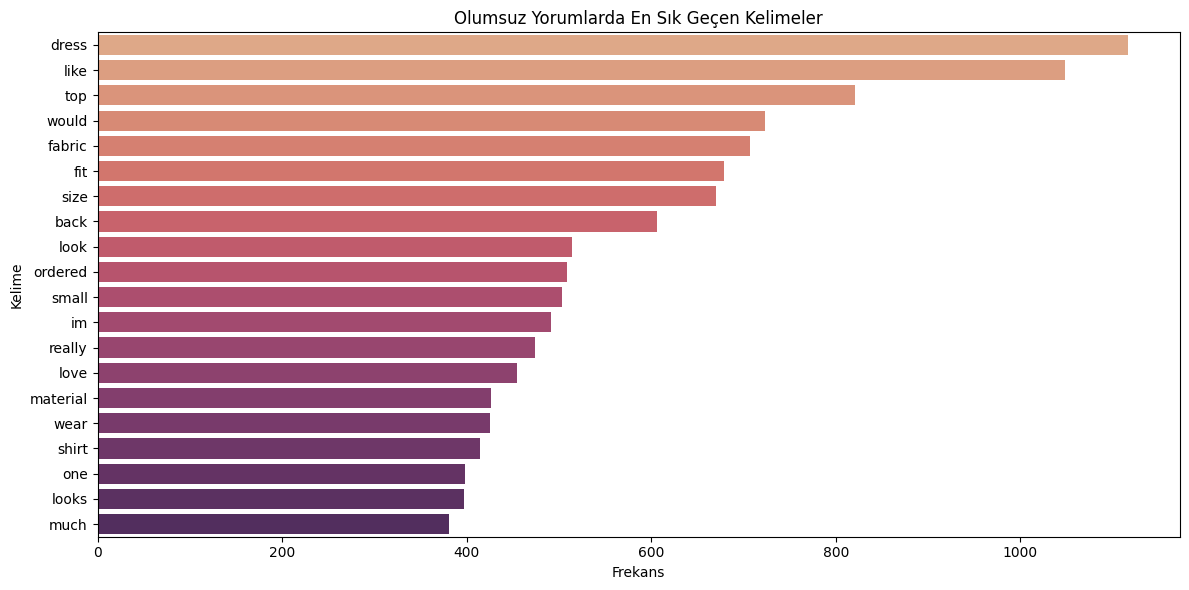

In [8]:
from collections import Counter

# Tüm kelimeleri birleştirip token'lara ayır
all_words = " ".join(negative_reviews['Clean_Review']).split()

# En sık geçen 20 kelimeyi say
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

# Görsel gösterim
words, counts = zip(*common_words)
plt.figure(figsize=(12,6))
sns.barplot(x=list(counts), y=list(words), palette="flare")
plt.title("Olumsuz Yorumlarda En Sık Geçen Kelimeler")
plt.xlabel("Frekans")
plt.ylabel("Kelime")
plt.tight_layout()
plt.show()


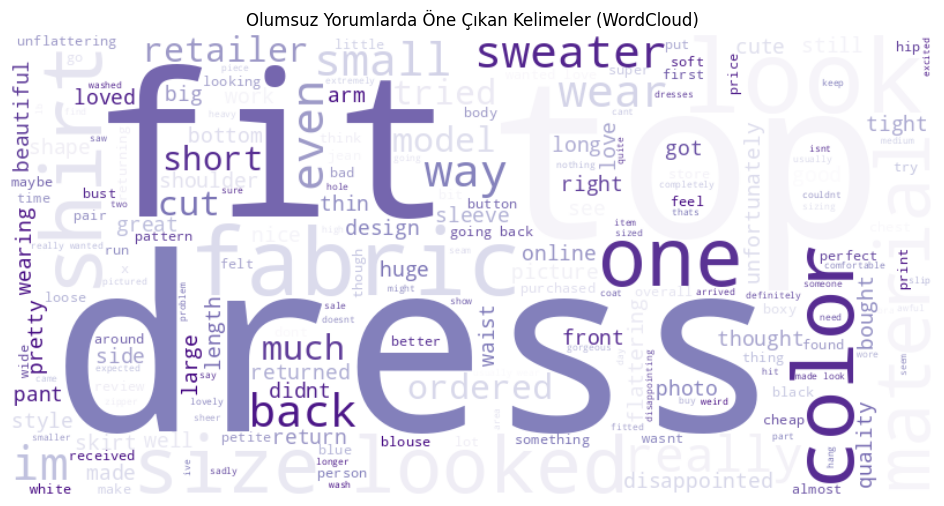

In [9]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Purples').generate(" ".join(all_words))

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Olumsuz Yorumlarda Öne Çıkan Kelimeler (WordCloud)")
plt.show()


In [10]:
from textblob import TextBlob
import nltk
nltk.data.path.append("/tam/yol/nltk_data")  # örneğin: "/home/kullanici/nltk_data"



In [11]:
# TextBlob ile duygu analizi fonksiyonu
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Polarity: -1 (negatif) ile 1 (pozitif) arasında
df['polarity'] = df['Clean_Review'].apply(get_sentiment)

# Pozitif/negatif/nötr olarak sınıflandır
def label_sentiment(polarity):
    if polarity > 0.1:
        return "positive"
    elif polarity < -0.1:
        return "negative"
    else:
        return "neutral"

df['sentiment'] = df['polarity'].apply(label_sentiment)

# İlk örnekleri görelim
df[['Clean_Review', 'polarity', 'sentiment']].head(10)


,Clean_Review,polarity,sentiment
0,absolutely wonderful silky sexy comfortable,0.633333,positive
1,love dress sooo pretty happened find store im ...,0.318750,positive
2,high hopes dress really wanted work initially ...,0.082300,neutral
3,love love love jumpsuit fun flirty fabulous ev...,0.500000,positive
4,shirt flattering due adjustable front tie perf...,0.458333,positive
5,love tracy reese dresses one petite feet tall ...,0.150000,positive
6,aded basket hte last mintue see would look lik...,0.075625,neutral
7,ordered carbon store pick ton stuff always try...,0.196154,positive
8,love dress usually get xs runs little snug bus...,-0.046875,neutral
9,im lbs ordered petite make sure length wasnt l...,0.212554,positive


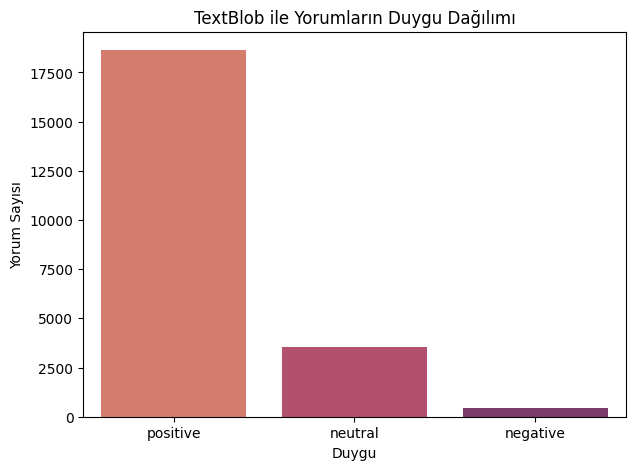

In [12]:
plt.figure(figsize=(7, 5))
sns.countplot(x='sentiment', data=df, palette="flare")
plt.title("TextBlob ile Yorumların Duygu Dağılımı")
plt.xlabel("Duygu")
plt.ylabel("Yorum Sayısı")
plt.show()


In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


In [14]:
# Yalnızca olumsuz yorumlar üzerinden topic modeling yapmak daha anlamlı
negative_text = negative_reviews['Clean_Review'].dropna()

# Sayı temsiline dönüştür
vectorizer = CountVectorizer(max_df=0.95, min_df=5, stop_words='english')
dtm = vectorizer.fit_transform(negative_text)


In [15]:
# 5 konu tespit etmeye çalışacağız (değiştirilebilir)
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(dtm)


LatentDirichletAllocation(n_components=5, random_state=42)

In [16]:
# Her konudaki en anlamlı 10 kelimeyi yazdıralım
def display_topics(model, feature_names, no_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"Konu {idx+1}:")
        print(" | ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()

no_top_words = 10
tf_feature_names = vectorizer.get_feature_names_out()
display_topics(lda_model, tf_feature_names, no_top_words)


Konu 1:
dress | like | fit | love | really | look | sweater | size | ordered | petite

Konu 2:
dress | like | fabric | looks | cheap | looked | material | quality | price | felt

Konu 3:
shirt | fabric | small | skirt | love | wear | size | im | really | fit

Konu 4:
dress | color | pants | wear | fit | size | bought | jeans | fabric | quality

Konu 5:
size | ordered | like | fit | look | im | small | material | large | fabric



In [17]:
# Her yorum için en yüksek olasılıkla ait olduğu topic'i bulalım
topic_values = lda_model.transform(dtm)
topic_labels = topic_values.argmax(axis=1)

# Orijinal dataframe'e konu etiketi ekleyelim
negative_text_df = negative_text.reset_index(drop=True).to_frame()
negative_text_df['Topic'] = topic_labels + 1  # Konu 1, 2, 3 şeklinde başlasın

# İlk 10 yorum ve tahmini konuları görelim
negative_text_df.head(10)


,Clean_Review,Topic
0,love tracy reese dresses one petite feet tall ...,1
1,first pullover styling side zipper wouldnt pur...,1
2,waiting sweater coat ship weeks excited arrive...,4
3,ordered months ago finally came back order hug...,2
4,pregnant thought would great sleep bra soft fi...,1
5,tags sewn small long huge x itchy cut thread l...,2
6,really loved top online wanted love person sof...,4
7,designers keep making crop tops cant imagine w...,5
8,zipper broke piece first time wore disappointi...,4
9,really hoping like look way model least sharkb...,5


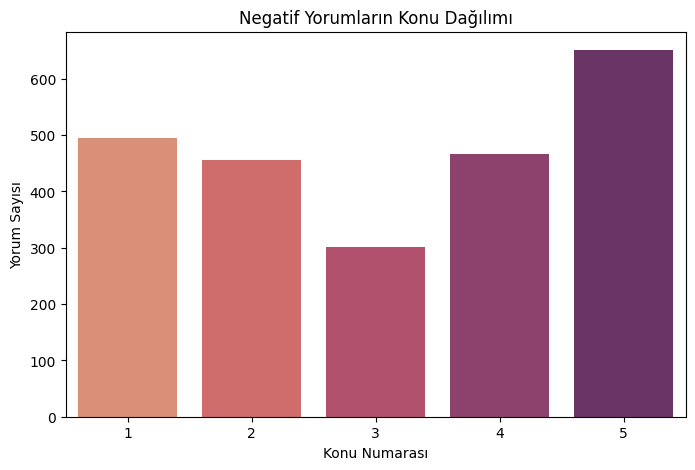

In [18]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Topic', data=negative_text_df, palette="flare")
plt.title("Negatif Yorumların Konu Dağılımı")
plt.xlabel("Konu Numarası")
plt.ylabel("Yorum Sayısı")
plt.show()


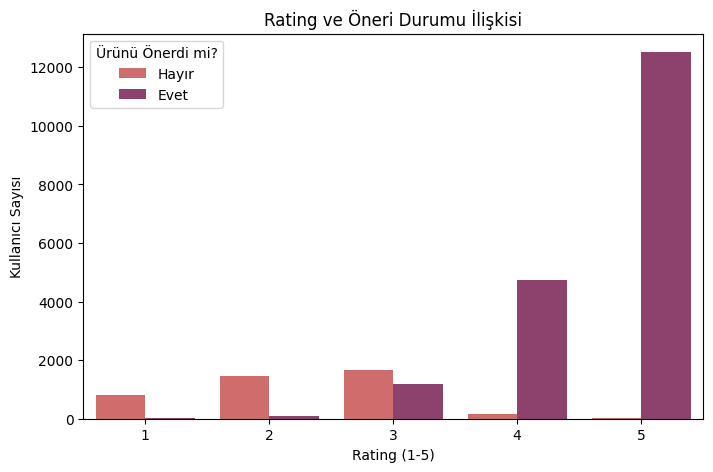

In [19]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Rating', hue='Recommended_IND', palette='flare')
plt.title("Rating ve Öneri Durumu İlişkisi")
plt.xlabel("Rating (1-5)")
plt.ylabel("Kullanıcı Sayısı")
plt.legend(title="Ürünü Önerdi mi?", labels=["Hayır", "Evet"])
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


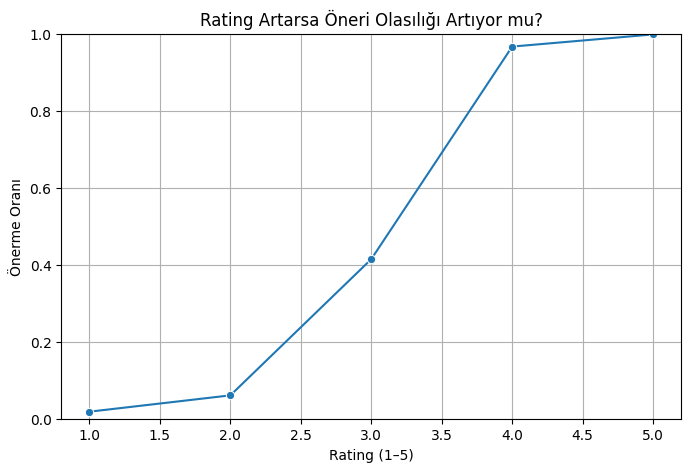

In [20]:
# Rating'e göre öneri oranı
recommend_by_rating = df.groupby('Rating')['Recommended_IND'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.lineplot(data=recommend_by_rating, x='Rating', y='Recommended_IND', marker='o')
plt.title("Rating Artarsa Öneri Olasılığı Artıyor mu?")
plt.xlabel("Rating (1–5)")
plt.ylabel("Önerme Oranı")
plt.ylim(0, 1)
plt.grid(True)
plt.show()


In [21]:
from scipy.stats import chi2_contingency

# Kontenjans tablosu
contingency_table = pd.crosstab(df['Rating'], df['Recommended_IND'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print(f"Chi-Square Değeri: {chi2:.2f}")
print(f"p-değeri: {p_value:.5f}")


Chi-Square Değeri: 16103.98
p-değeri: 0.00000


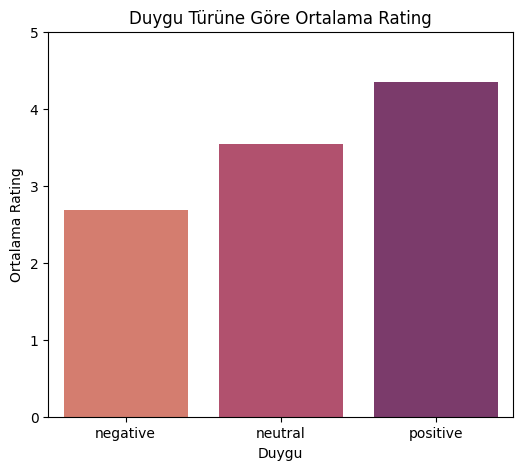

In [22]:
# Rating ortalamalarını her duygu türü için hesapla
mean_rating_by_sentiment = df.groupby('sentiment')['Rating'].mean().reset_index()

plt.figure(figsize=(6, 5))
sns.barplot(data=mean_rating_by_sentiment, x='sentiment', y='Rating', palette='flare')
plt.title("Duygu Türüne Göre Ortalama Rating")
plt.xlabel("Duygu")
plt.ylabel("Ortalama Rating")
plt.ylim(0, 5)
plt.show()


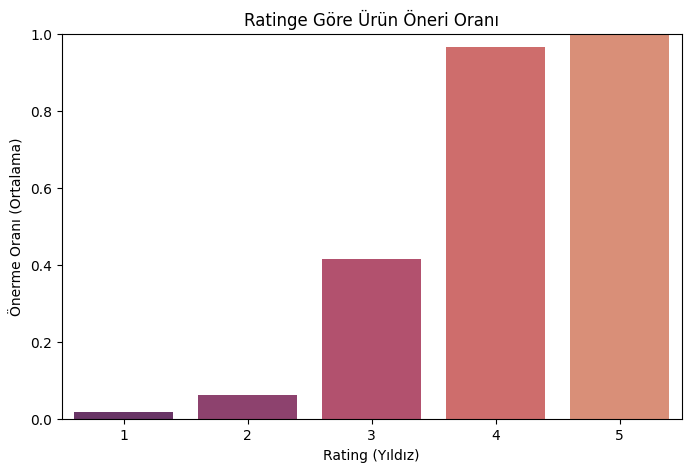

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Rating'e göre Recommended IND'nin ortalamasını (yani öneri oranını) hesapla
recommendation_rate = df.groupby('Rating')['Recommended_IND'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=recommendation_rate, x='Rating', y='Recommended_IND', palette='flare_r')
plt.title('Ratinge Göre Ürün Öneri Oranı')
plt.xlabel('Rating (Yıldız)')
plt.ylabel('Önerme Oranı (Ortalama)')
plt.ylim(0,1)
plt.show()


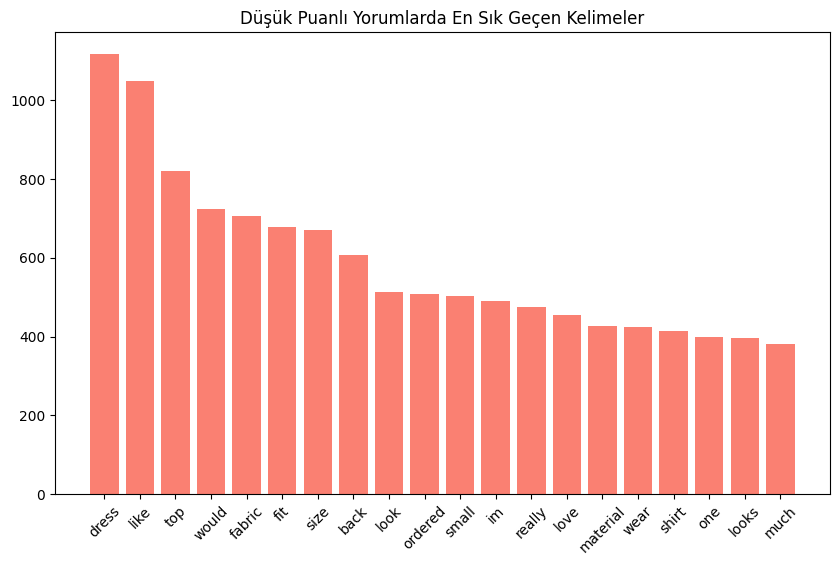

In [24]:
import matplotlib.pyplot as plt

words, counts = zip(*common_words)

plt.figure(figsize=(10,6))
plt.bar(words, counts, color='salmon')
plt.xticks(rotation=45)
plt.title('Düşük Puanlı Yorumlarda En Sık Geçen Kelimeler')
plt.show()


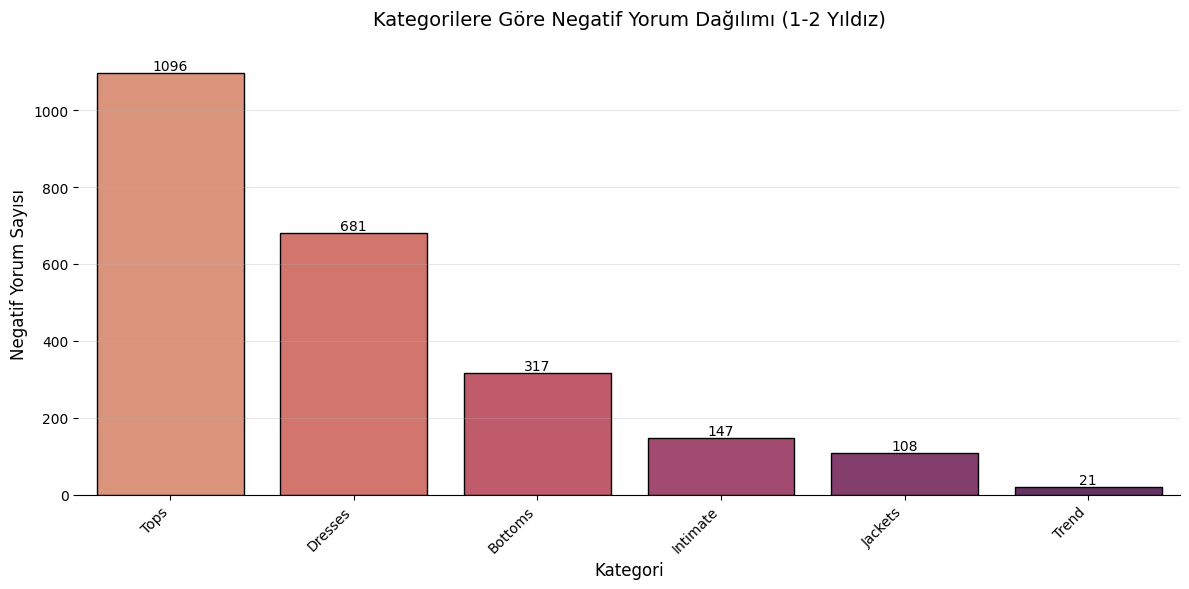

In [25]:

negatif_yorumlar = df[df['Rating'] <= 2]

# Kategori bazında negatif yorum sayılarını hesapla (Department_Name veya Class_Name seçilebilir)
kategori_negatif = negatif_yorumlar['Department_Name'].value_counts().reset_index()
kategori_negatif.columns = ['Kategori', 'Negatif_Yorum_Sayisi']

# Renk paleti belirle (negatif vurgusu için kırmızı tonları)
colors = sns.color_palette("flare", len(kategori_negatif))

# Grafik oluştur
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='Kategori', 
    y='Negatif_Yorum_Sayisi', 
    data=kategori_negatif,
    palette=colors,
    edgecolor='black'
)

# Grafik detayları
plt.title('Kategorilere Göre Negatif Yorum Dağılımı (1-2 Yıldız)', fontsize=14, pad=20)
plt.xlabel('Kategori', fontsize=12)
plt.ylabel('Negatif Yorum Sayısı', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Kategori isimlerini 45 derece döndür

# Çubukların üzerine değerleri yaz
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', 
        va='center', 
        xytext=(0, 5), 
        textcoords='offset points',
        fontsize=10
    )

# İnce ayarlar
sns.despine(left=True)  # Sol çerçeveyi kaldır
plt.grid(axis='y', alpha=0.3)  # Yatay grid çizgileri
plt.tight_layout()  # Sıkışık görünümü engelle

plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


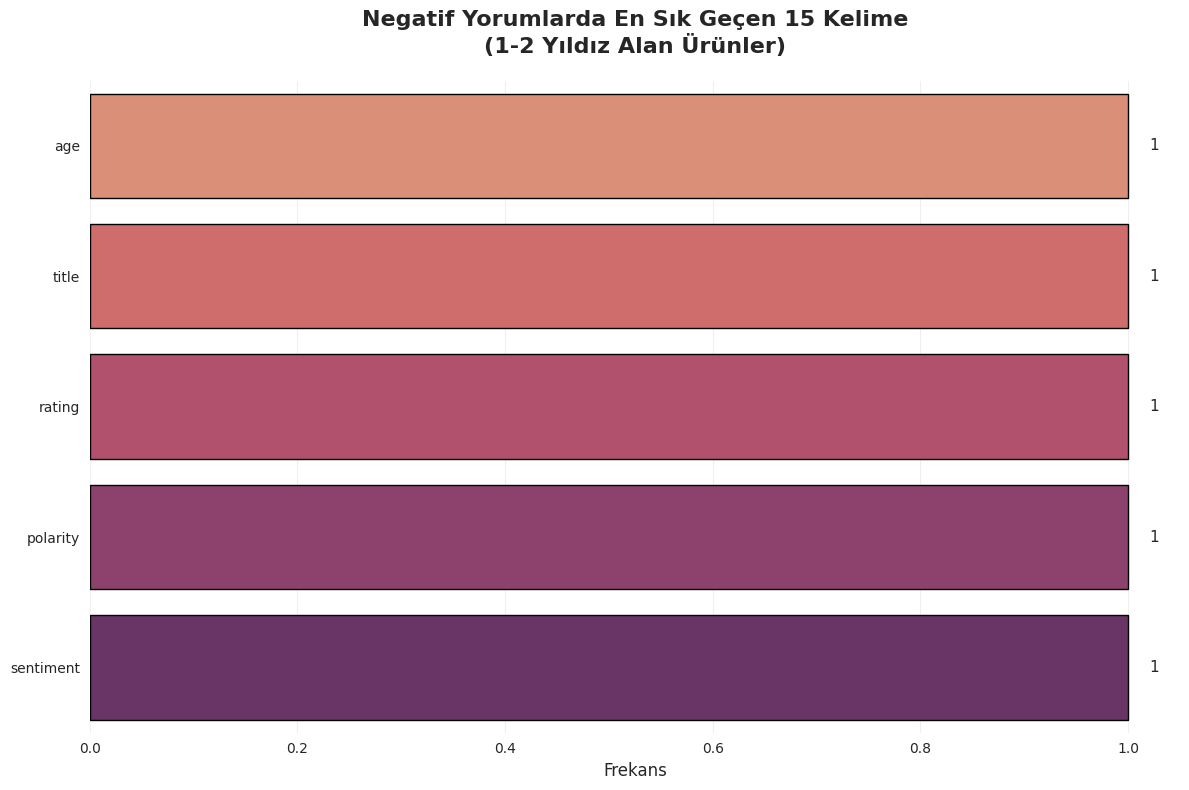

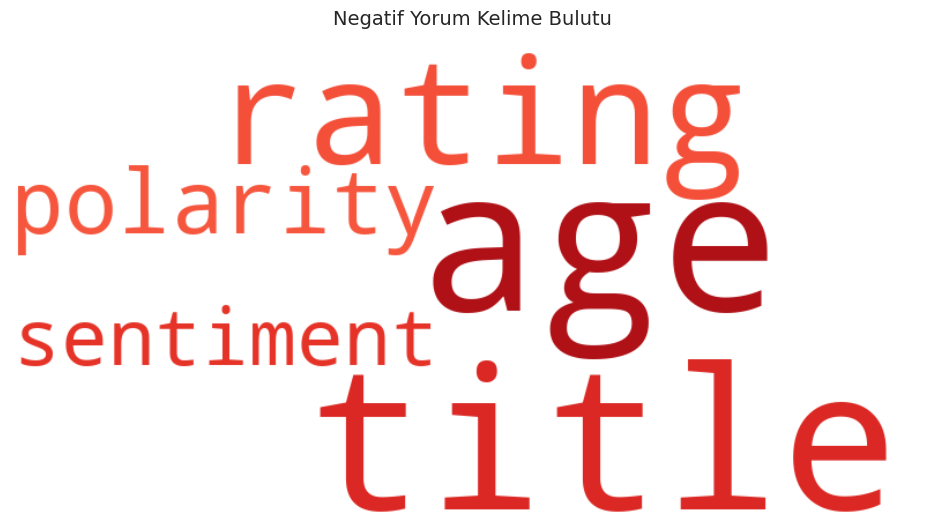

In [26]:
# 2. Kelime Frekanslarını Hesapla
def kelime_analizi(text_serisi, stop_words=None):
    if stop_words is None:
        stop_words = set()  # İsteğe bağlı ek stopwords ekleyebilirsiniz
    
    tum_kelimeler = ' '.join(text_serisi).lower().split()
    temiz_kelimeler = [kelime for kelime in tum_kelimeler
                      if (kelime.isalpha()) and (kelime not in stop_words)]
    
    return Counter(temiz_kelimeler).most_common(15)

kelime_frekans = kelime_analizi(negatif_yorumlar)

# 3. Çubuk Grafik
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Renk paleti (kırmızı tonları)
palette = sns.color_palette("flare", len(kelime_frekans))

# Yatay bar grafik
bars = sns.barplot(
    x=[count for word, count in kelime_frekans],
    y=[word for word, count in kelime_frekans],
    palette=palette,
    edgecolor="black"
)

# Grafik detayları
plt.title('Negatif Yorumlarda En Sık Geçen 15 Kelime\n(1-2 Yıldız Alan Ürünler)', 
          fontsize=16, pad=20, fontweight='bold')
plt.xlabel('Frekans', fontsize=12)
plt.ylabel('')
plt.grid(axis='x', alpha=0.3)

# Değer etiketleri ekle
for i, (word, count) in enumerate(kelime_frekans):
    plt.text(count + max([c for w,c in kelime_frekans])*0.02, 
             i, 
             f'{count}', 
             va='center',
             fontsize=11)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

# 4. Kelime Bulutu (Bonus)
wordcloud = WordCloud(
    width=800, 
    height=400,
    background_color='white',
    colormap='Reds',
    max_words=50
).generate_from_frequencies(dict(kelime_frekans))

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negatif Yorum Kelime Bulutu', fontsize=14, pad=20)
plt.show()

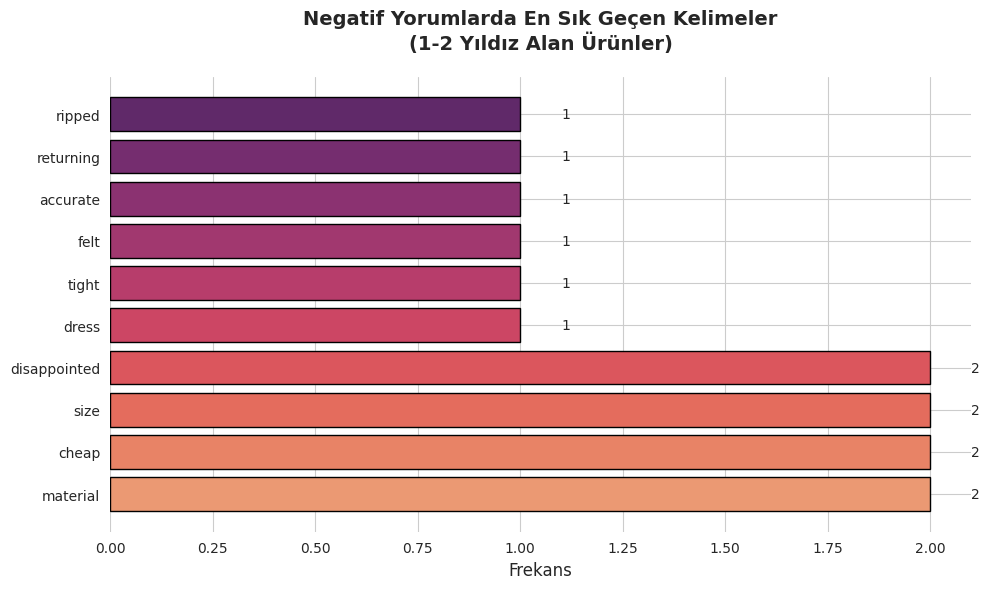

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd
import re

# 1. Veri Hazırlığı (Örnek veri - sizin df'nizle değiştirin)
data = {
    'Review_Text': [
        'This dress was too tight and the material felt cheap',
        'Size not accurate, returning it',
        'Disappointed. It ripped after first wear',
        'The size was too small, very disappointed',
        'Cheap material, would not buy again'
    ],
    'Rating': [1, 2, 1, 2, 1]
}
df = pd.DataFrame(data)

# 2. Kelime Analizi Fonksiyonu
def analyze_negative_reviews(df, rating_threshold=2):
    # Stopwords listesi (İhtiyaca göre genişletin)
    stop_words = {'the', 'and', 'it', 'this', 'was', 'not', 'too', 'after', 'again'}
    
    # Negatif yorumları filtrele
    neg_reviews = df[df['Rating'] <= rating_threshold]['Review_Text'].dropna()
    
    # Kelimeleri çıkar ve temizle
    words = []
    for review in neg_reviews:
        cleaned_words = re.findall(r'\b[a-z]{3,}\b', review.lower())  # 3+ harfli kelimeler
        words.extend([word for word in cleaned_words if word not in stop_words])
    
    return Counter(words).most_common(10)

# 3. Kelime frekanslarını hesapla
word_counts = analyze_negative_reviews(df)

# 4. Görselleştirme
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Renk paleti (kırmızı tonları)
colors = sns.color_palette("flare", len(word_counts))

# Yatay bar grafik
words = [word[0] for word in word_counts]
counts = [word[1] for word in word_counts]

bars = plt.barh(words, counts, color=colors, edgecolor='black')

# Grafik başlık ve etiketler
plt.title('Negatif Yorumlarda En Sık Geçen Kelimeler\n(1-2 Yıldız Alan Ürünler)', 
          fontsize=14, pad=20, fontweight='bold')
plt.xlabel('Frekans', fontsize=12)
plt.ylabel('')

# Değer etiketleri ekle
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, 
             bar.get_y() + bar.get_height()/2, 
             f'{int(width)}', 
             va='center')

# Eksenleri temizle
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


In [29]:
# Veri dosyasını yükleyelim
df = pd.read_csv("/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv")

# Yalnızca gerekli sütunlar
df = df[['Review Text', 'Rating']]
df.dropna(inplace=True)

# Duygu etiketleme: Rating'e göre ya da TextBlob ile
def get_sentiment(text):
    polarity = TextBlob(str(text)).sentiment.polarity
    if polarity > 0.2:
        return "positive"
    elif polarity < -0.2:
        return "negative"
    else:
        return "neutral"

df["Sentiment"] = df["Review Text"].apply(get_sentiment)

# İsteğe bağlı: Nötr yorumları çıkarabilirsin
df = df[df["Sentiment"] != "neutral"]


In [30]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
X = vectorizer.fit_transform(df["Review Text"])
y = df["Sentiment"]


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Naive Bayes Raporu:
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00        24
    positive       0.99      1.00      1.00      2734

    accuracy                           0.99      2758
   macro avg       0.50      0.50      0.50      2758
weighted avg       0.98      0.99      0.99      2758



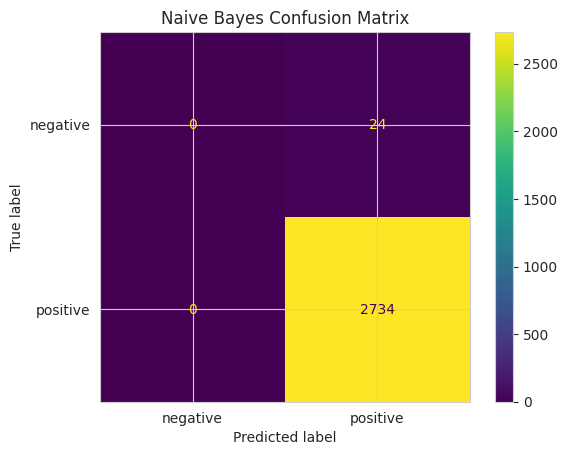

In [32]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

print("Naive Bayes Raporu:\n", classification_report(y_test, y_pred_nb))
ConfusionMatrixDisplay.from_estimator(nb_model, X_test, y_test)
plt.title("Naive Bayes Confusion Matrix")
plt.show()


KNN Raporu:
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00        24
    positive       0.99      1.00      1.00      2734

    accuracy                           0.99      2758
   macro avg       0.50      0.50      0.50      2758
weighted avg       0.98      0.99      0.99      2758



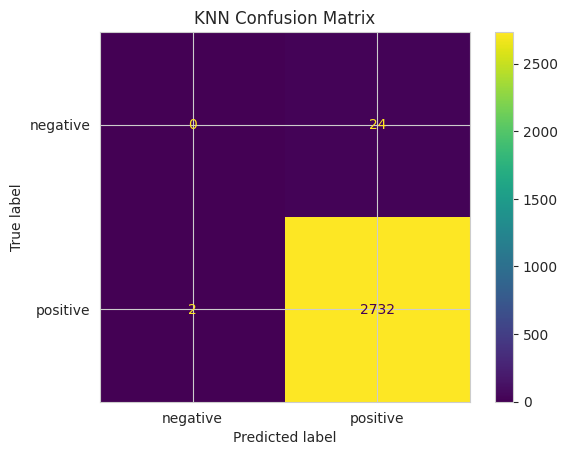

In [33]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

print("KNN Raporu:\n", classification_report(y_test, y_pred_knn))
ConfusionMatrixDisplay.from_estimator(knn_model, X_test, y_test)
plt.title("KNN Confusion Matrix")
plt.show()


Decision Tree Raporu:
               precision    recall  f1-score   support

    negative       0.35      0.38      0.36        24
    positive       0.99      0.99      0.99      2734

    accuracy                           0.99      2758
   macro avg       0.67      0.68      0.68      2758
weighted avg       0.99      0.99      0.99      2758



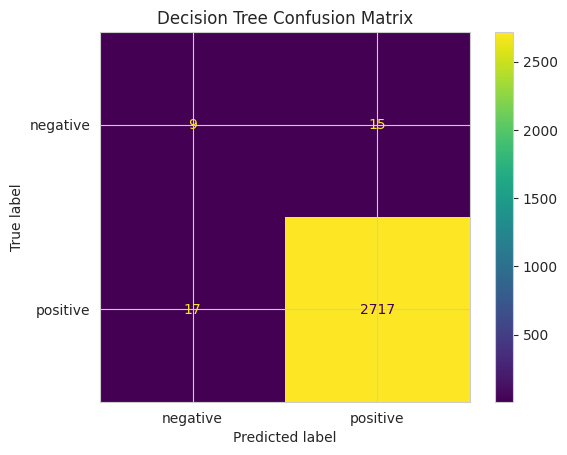

In [34]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

print("Decision Tree Raporu:\n", classification_report(y_test, y_pred_tree))
ConfusionMatrixDisplay.from_estimator(tree_model, X_test, y_test)
plt.title("Decision Tree Confusion Matrix")
plt.show()


In [35]:
df = pd.read_csv('/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv', index_col=0)

# Memnuniyetsiz yorumları filtreleme (Rating 1-3 olanlar)
dissatisfied = df[df['Rating'] <= 3].copy()

dissatisfied = dissatisfied.assign(**{'Review Text': dissatisfied['Review Text'].fillna('')})
dissatisfied = dissatisfied[dissatisfied['Review Text'] != '']

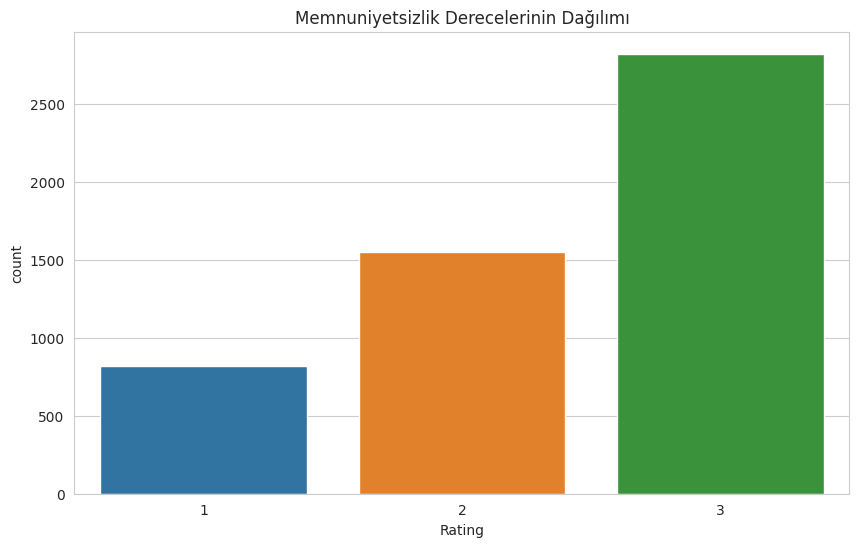

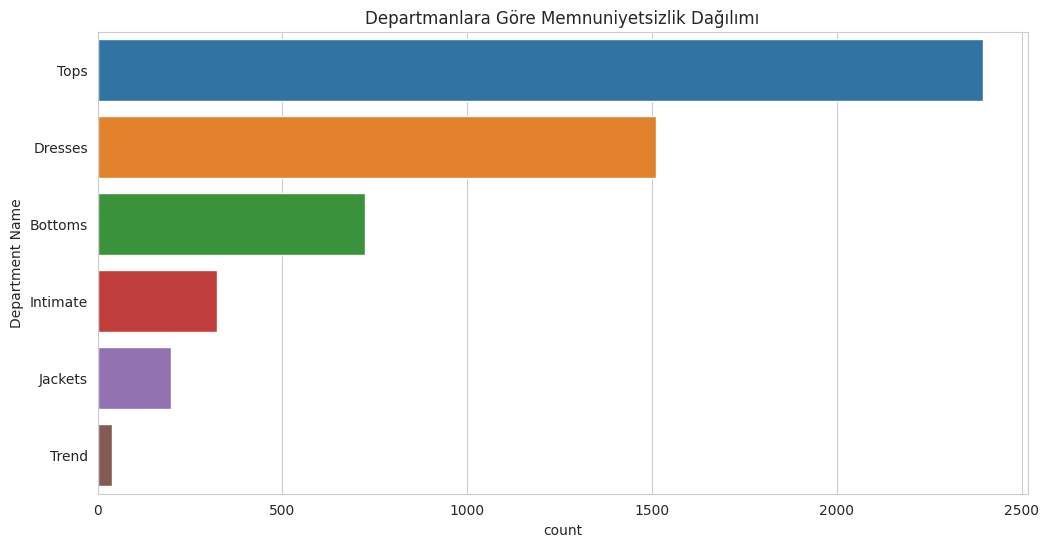

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


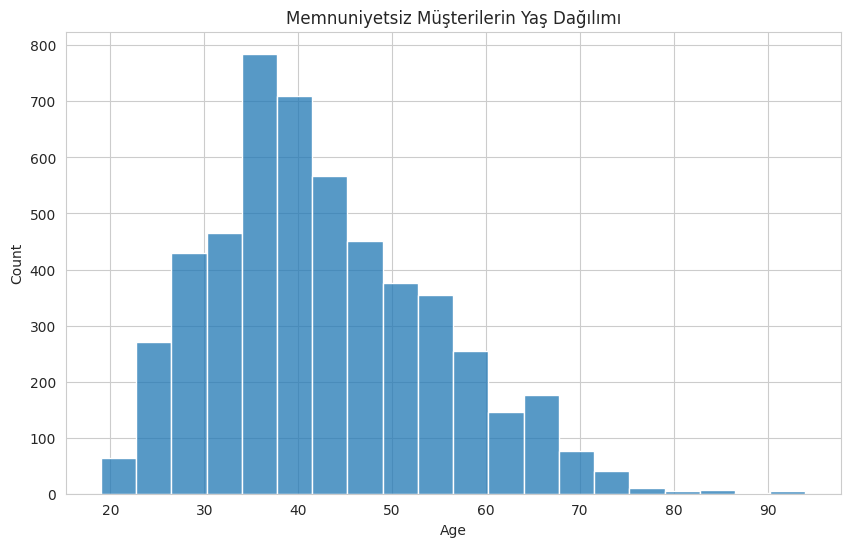

In [36]:
# Memnuniyetsizlik dağılımı
plt.figure(figsize=(10,6))
sns.countplot(x='Rating', data=dissatisfied)
plt.title('Memnuniyetsizlik Derecelerinin Dağılımı')
plt.show()

# Kategorilere göre memnuniyetsizlik
plt.figure(figsize=(12,6))
sns.countplot(y='Department Name', data=dissatisfied, order=dissatisfied['Department Name'].value_counts().index)
plt.title('Departmanlara Göre Memnuniyetsizlik Dağılımı')
plt.show()

# Yaş dağılımı
plt.figure(figsize=(10,6))
sns.histplot(dissatisfied['Age'], bins=20)
plt.title('Memnuniyetsiz Müşterilerin Yaş Dağılımı')
plt.show()

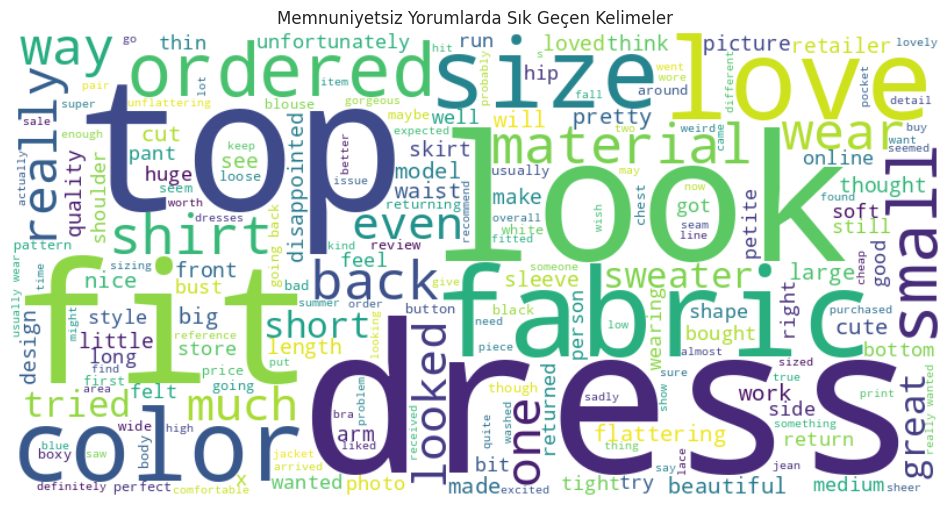

En negatif 10 yorum:
                                             Review Text  Rating  \
14754  Cut out design, no seems or hems.\r\n very dis...       1   
20502  Received this product with a gaping hole in it...       1   
6296   Awful color, horribly wrinkled and just a mess...       2   
5114   What a disappointment and for the price, it's ...       1   
12846  The button fell off when i took it out of the ...       2   
19474  I was really disappointed when this arrived an...       3   
14097  This arrived this week and i was so disappoint...       2   
2258   Hangs terribly off the chest. tent-like. looks...       3   
10364  These are terribly unflattering the wash looks...       1   
12553  40% sweaters...i couldn't pass it up. unfortun...       3   

      Department Name  
14754            Tops  
20502            Tops  
6296          Dresses  
5114             Tops  
12846         Jackets  
19474        Intimate  
14097         Jackets  
2258             Tops  
10364         

In [37]:
# Negatif yorumlardan kelime bulutu oluşturma
text = ' '.join(review for review in dissatisfied['Review Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Memnuniyetsiz Yorumlarda Sık Geçen Kelimeler')
plt.show()

# Duygu analizi yapalım
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

dissatisfied['Sentiment'] = dissatisfied['Review Text'].apply(get_sentiment)

# En negatif 10 yorum
print("En negatif 10 yorum:")
print(dissatisfied.nsmallest(10, 'Sentiment')[['Review Text', 'Rating', 'Department Name']])

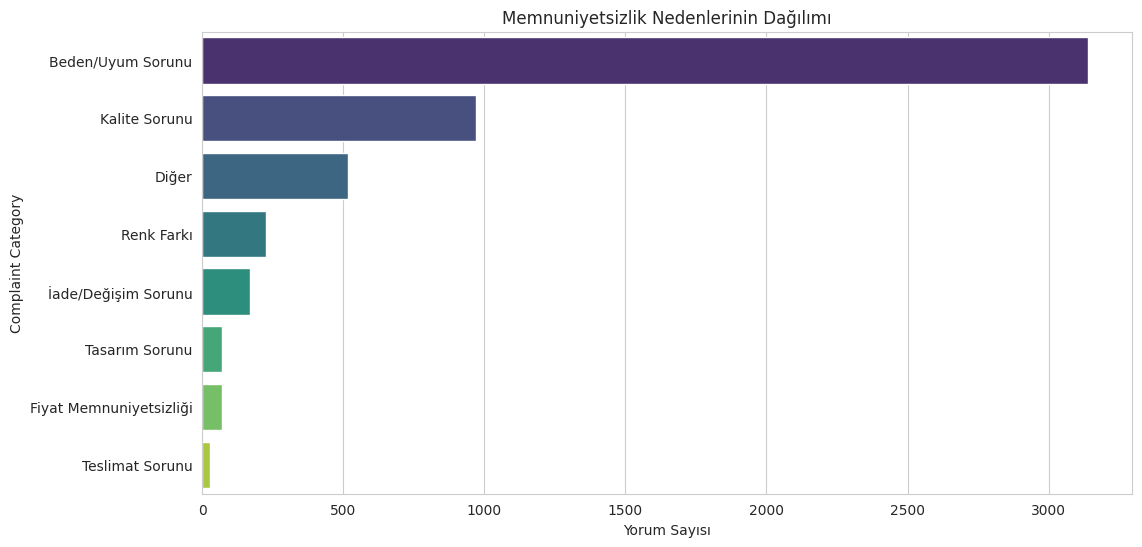

In [38]:
# Memnuniyetsizlik nedenlerini kategorize etme fonksiyonu
def categorize_complaint(text):
    text = str(text).lower()
    if 'size' in text or 'fit' in text or 'small' in text or 'large' in text:
        return 'Beden/Uyum Sorunu'
    elif 'quality' in text or 'material' in text or 'fabric' in text:
        return 'Kalite Sorunu'
    elif 'color' in text or 'colour' in text:
        return 'Renk Farkı'
    elif 'return' in text or 'exchange' in text:
        return 'İade/Değişim Sorunu'
    elif 'delivery' in text or 'ship' in text or 'arrive' in text:
        return 'Teslimat Sorunu'
    elif 'price' in text or 'expensive' in text or 'cost' in text:
        return 'Fiyat Memnuniyetsizliği'
    elif 'design' in text or 'style' in text:
        return 'Tasarım Sorunu'
    else:
        return 'Diğer'

dissatisfied['Complaint Category'] = dissatisfied['Review Text'].apply(categorize_complaint)

# Şikayet kategorilerinin dağılımı
plt.figure(figsize=(12,6))
complaint_counts = dissatisfied['Complaint Category'].value_counts()
sns.barplot(x=complaint_counts.values, y=complaint_counts.index, palette='viridis')
plt.title('Memnuniyetsizlik Nedenlerinin Dağılımı')
plt.xlabel('Yorum Sayısı')
plt.show()

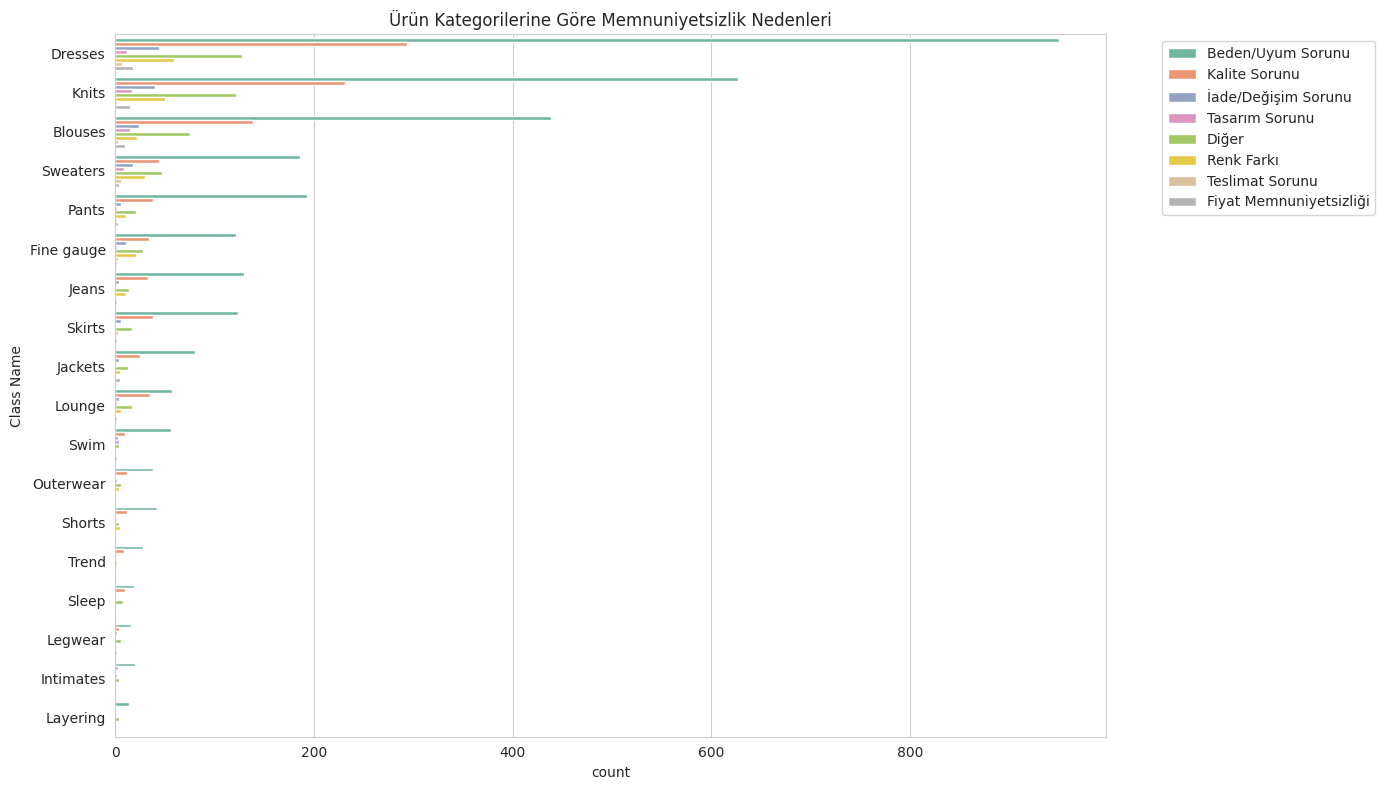

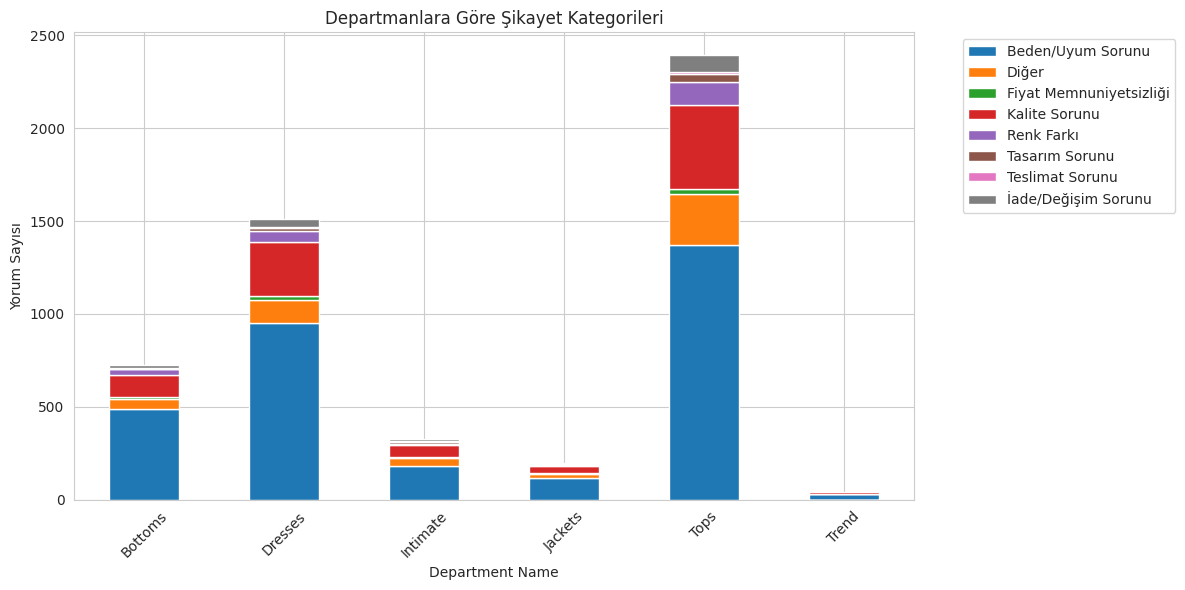

In [39]:
# Ürün kategorilerine göre şikayet dağılımı
plt.figure(figsize=(14,8))
sns.countplot(y='Class Name', hue='Complaint Category', 
              data=dissatisfied, 
              order=dissatisfied['Class Name'].value_counts().index,
              palette='Set2')
plt.title('Ürün Kategorilerine Göre Memnuniyetsizlik Nedenleri')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Department ve Division'a göre şikayet analizi
pd.crosstab(dissatisfied['Department Name'], dissatisfied['Complaint Category']).plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Departmanlara Göre Şikayet Kategorileri')
plt.ylabel('Yorum Sayısı')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()